# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 練習特徵重要性的寫作與觀察

# [作業重點]
- 仿造範例, 完成特徵重要性的計算, 並觀察對預測結果的影響 (In[3]~[5], Out[3]~[5]) 
- 仿造範例, 將兩個特徵重要性最高的特徵重組出新特徵, 並觀察對預測結果的影響 (In[8], Out[8]) 

In [58]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

data_path = 'data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']                            # 取出目標值
df = df.drop(['PassengerId', 'Survived'] , axis=1)  # 刪除[乘客ID , 目標值]欄位
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [59]:
'''
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()
'''

"\n# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程\nLEncoder = LabelEncoder()\nMMEncoder = MinMaxScaler()\nfor c in df.columns:\n    df[c] = df[c].fillna(-1)\n    if df[c].dtype == 'object':\n        df[c] = LEncoder.fit_transform(list(df[c].values))\n    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))\ndf.head()\n"

In [60]:
# 我自己的想法，把類別型欄位缺值補'None'，再補數值型欄位缺值為[-1] 
# // 因為不太懂為何要使用[ list(df[c].values) ]，應該說要如何使用  
# // 有測試過兩者差別，分數差不多

LEncoder = LabelEncoder()                                        # 設定 LabelEncoding
MMEncoder = MinMaxScaler()                                       # 設定最大最小化
for c in df.columns:
    if df[c].dtype == 'object':                                  # 篩選出類別型欄位
        df[c] = df[c].fillna('None')                             # 填補缺值為['None]
        df[c] = LEncoder.fit_transform(df[c])       # 進行 LabelEncoding

    df[c] = df[c].fillna(-1)                                     # 填補數值型欄位缺值為[-1]

    # 這邊其實可以'不用'特別做最大最小化，因為後面要計算時還會再做
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1)) # 進行最大最小化 
    
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.993197,1.0
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.551020,0.0
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.993197,1.0
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.374150,1.0
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.993197,1.0


In [61]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序
estimator = RandomForestClassifier()                    # 設定隨機森林
estimator.fit(df.values, train_Y)                       # 進行 fit 計算
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)    # 將特徵重要型，和其特徵名稱合成 Series
feats = feats.sort_values(ascending=False)              # 將 [特徵重要性] 由高到低排序

feats

Sex         0.248878
Ticket      0.159987
Name        0.141488
Fare        0.130106
Age         0.109757
Cabin       0.071357
Pclass      0.056690
SibSp       0.030766
Parch       0.030739
Embarked    0.020233
dtype: float64

## 先用隨機森林對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?

# Ans : 
## 假如只取前五名，分數比原始特徵低，但取前七名會比原始特徵高。


In [62]:
# 高重要性特徵(前五名、一半) + 隨機森林
high_feature = list(feats[:5].index)                        # 將[特徵重要性]較高的前半段取出

train_X = MMEncoder.fit_transform(df[high_feature])         # 做最大最小化 
cross_val_score(estimator, train_X, train_Y, cv=5).mean()   # 計算交叉分數

0.8204130311970372

In [63]:
# 高重要性特徵(前7名)
high_feature = list(feats[:7].index)
train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean() 

0.8227041616973196

In [64]:
# 原始特徵 + 隨機森林
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.824938798568828

# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?

# Ans : 
## 根據我的結果，分數有稍許的提升

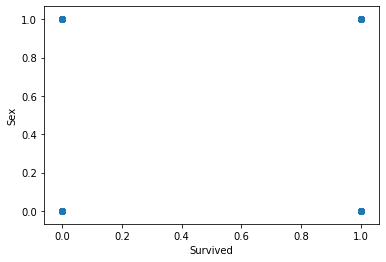

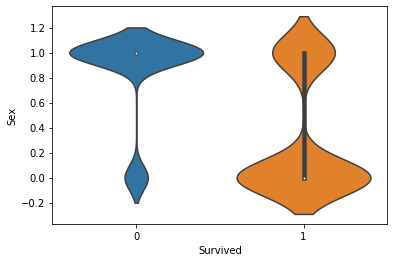

In [69]:
# 觀察重要特徵與目標的分布
# 第一名              
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x=train_Y, y=df['Sex'], fit_reg=False)     # # 畫回歸線圖 // fit_reg 指是否畫出回歸線
plt.show()  

# 小提琴圖 : 類似 boxplot
sns.violinplot(x=train_Y, y=df['Sex'], fit_reg=False, scale="width")     # scale='width'，為每把小提琴都有相同寬度
plt.show()  

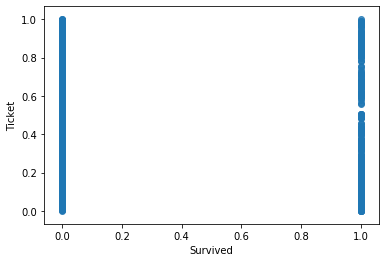

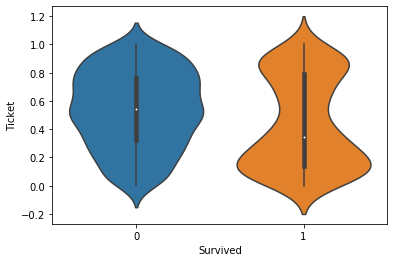

In [70]:
# 第二名       
sns.regplot(x=train_Y, y=df['Ticket'], fit_reg=False)
plt.show()

sns.violinplot(x=train_Y, y=df['Ticket'], fit_reg=False, scale='width')

In [67]:
# 製作新特徵看效果
df['newf_1'] = (df['Sex']+df['Ticket'])/2                       # 相加/2
df['newf_2'] = df['Sex']*df['Ticket']                           # 相乘
df['newf_3'] = df['Sex']/(df['Ticket']+1) *2                    # 2 * x1/(x2+1)
df['newf_4'] = df['Ticket']/(df['Sex']+1) *2                    # 2 * x2/(x1+1)
df['newf_5'] = ((df['Sex'])**2+(df['Ticket'])**2)**0.5          # ( x1^2 + x2^2 )^0.5

train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8350134957002071